In [6]:
# Importamos librerias necesarias
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16 # Modelo VGG16
## Importamos las capas de la red
from keras.layers import Dense, Flatten, Dropout
# Importamos un preprocesador de imagenes
from keras.preprocessing.image import ImageDataGenerator
# Importamos el modelo base
from keras.models import Model
# Importamos un metodo de regularizacion
from keras.regularizers import l2
# Importamos el callback de EarlyStopping
from keras.callbacks import EarlyStopping

In [7]:
# Definimos un modelo de CNN
def clasificador():
    # Cargamos el modelo VGG16
    modelo = VGG16(include_top=False, input_shape=(224,224,3), weights=None)
    # Añadimos capas adicionales
    x = modelo.output
    x = Flatten()(x)
    x = Dense(units=256, activation="relu", kernel_initializer="he_uniform")(x)
    output = Dense(units=1, activation="sigmoid", kernel_initializer="he_uniform")(x)
    modelo = Model(inputs=modelo.input, outputs=output)
    # Compilamos el modelo
    modelo.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    # Mostramos el resumen del modelo
    modelo.summary()
    return modelo

In [8]:
# Generamos gráficos de diagnóstico
def diagnostic_graphs(history):
    # Función de perdida
    plt.figure()
    plt.title("Función de pérdida")
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, "k--", label="Training loss")
    plt.plot(epochs, val_loss, "g--", label="Testing loss")
    plt.legend()
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig("loss.pdf")
    plt.show()

    # Accuracy
    plt.figure()
    plt.title("Accuracy")
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "k--", label="Training accuracy")
    plt.plot(epochs, val_acc, "g--", label="Testing accuracy")
    plt.legend()
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.savefig("accuracy.pdf")
    plt.show()

In [9]:
def run_test_harness():
	# Definimos el modelo
	modelo = clasificador()
	# Definimos un early stopping
	early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
	# Creamos un generador de datos
	train_datagen = ImageDataGenerator(
		featurewise_center=True,
		horizontal_flip=True,
		vertical_flip=True,
		rotation_range=90
	)
	test_datagen = ImageDataGenerator(featurewise_center=True)
	# Especificamos los valores promedio de imagenet
	imagenet_mean = [103.939, 116.779, 123.68]
	train_datagen.mean = imagenet_mean
	test_datagen.mean = imagenet_mean

	# Definimos los iteradores de datos
	train_it = train_datagen.flow_from_directory(
		directory="Dataset_CNN/train/",
		class_mode="binary",
		batch_size=16,
		target_size=(224, 224), save_to_dir="Dataset_CNN/train_augmented/"
	)
	test_it = test_datagen.flow_from_directory(
		directory="Dataset_CNN/test/",
		class_mode="binary",
		batch_size=16,
		target_size=(224, 224)
	)
	# Entrenamos el modelo
	history = modelo.fit(
		train_it,
		validation_data=test_it,
		validation_steps=len(test_it),
		epochs=50,
		verbose=2,
		callbacks=[early_stopping],
		shuffle=True
	)

	# Evaluamos el modelo
	_, accuracy = modelo.evaluate(x=test_it, steps=len(test_it), verbose=2)
	print(">> %.5f" % (accuracy * 100.0))

	# Generamos gráficos de diagnóstico
	diagnostic_graphs(history)

	# Imprimimos el valor de la precisión
	print(f"El valor de la precisión del modelo en entrenamiento es : {history.history['accuracy'][-1]*100:.4f} %")

	# Guardamos el modelo
	modelo.save("concrete_model.h5")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

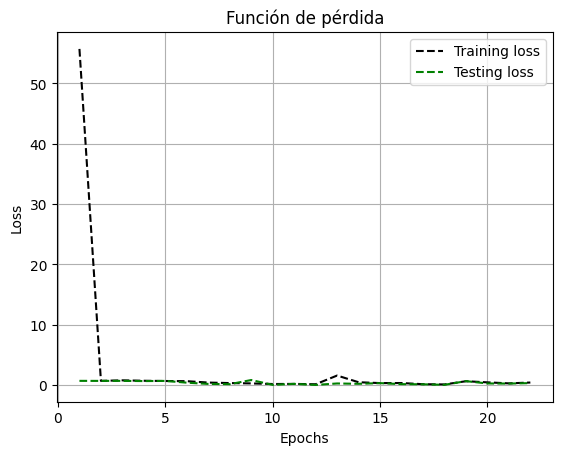

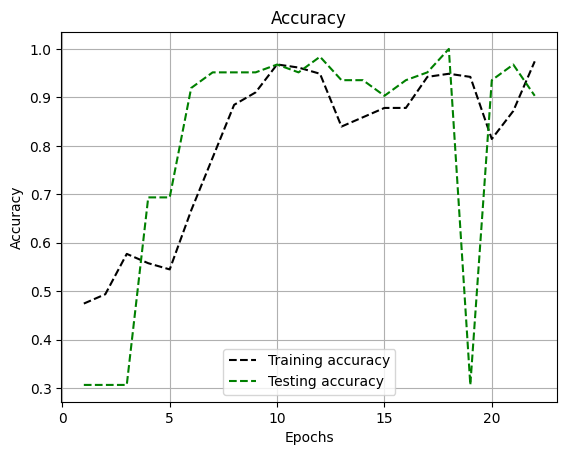

El valor de la precisión del modelo en entrenamiento es : 97.4359 %


In [10]:
# Entrenamos el modelo 🚀 
run_test_harness()